# Models

## Imports

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
pd.options.display.float_format = '{:.5f}'.format

In [4]:
SEED = 0

## Data Prep

In [5]:
df_train = pd.read_csv("../data/training_data.csv")
df_val   = pd.read_csv("../data/validation_data.csv")
df_test  = pd.read_csv("../data/testing_data_dirty.csv")

preprocessor = joblib.load("../models/pipeline.joblib")

In [6]:
np.log1p(df_test["price_raw"].values)

array([12.57418543, 12.7218888 , 13.29631837, ..., 14.13759478,
       12.48748888, 12.48748888], shape=(1535,))

In [7]:
df_X_train = df_train.drop(columns=["price_raw", "price_log"])
df_y_train = df_train[["price_raw", "price_log"]]

df_X_val   = df_val.drop(columns=["price_raw", "price_log"])
df_y_val   = df_val[["price_raw", "price_log"]]

df_X_test_orig = df_test.drop(columns=["price_raw"])
df_X_test = preprocessor.transform(df_test)
df_y_test  = df_test[["price_raw"]]
df_y_test["price_log"] = np.log1p(df_test["price_raw"])
df_X_train.head()

/tmp/ipykernel_73017/1786928942.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_test["price_log"] = np.log1p(df_test["price_raw"])


,bathrooms,indoor_surface,communal_pool,u/f_heating_climate_control,gym,communal_garden,domotics,private_pool,private_garden,barbeque,jacuzzi,luxury,bedrooms,alarm_system_security,games_room
0,0.33934,0.66670,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13636,0.00000,0.00000
1,0.41655,0.73068,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.13636,0.00000,0.00000
2,0.41655,0.56272,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.13636,0.00000,0.00000
3,0.09953,0.26059,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.23981,0.47419,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04545,0.00000,0.00000


In [8]:
X_train = df_X_train.values
X_val   = df_X_val.values
X_test  = df_X_test.values

y_train = df_y_train["price_log"].values
y_val   = df_y_val["price_log"].values
y_test  = df_y_test["price_log"].values

y_train_raw = df_y_train["price_raw"].values
y_val_raw  = df_y_val["price_raw"].values
y_test_raw = df_y_test["price_raw"].values

In [9]:
X_train_val = np.concat((X_train, X_val))
y_train_val = np.concat((y_train, y_val))
y_train_val_raw = np.concat((y_train_raw, y_val_raw))

## Errors

In [10]:
def get_errors(true, pred, fold=None, is_decision_tree=False):
    if is_decision_tree:
        true_r2 = true
        pred_r2 = pred
    else:
        true_r2 = np.log1p(true)
        pred_r2 = np.log1p(pred)
    result = pd.Series({
        "r2": r2_score(true_r2, pred_r2),
        # "mse": mean_squared_error(true, pred),
        "rmse": root_mean_squared_error(true, pred),
        "mae": mean_absolute_error(true, pred),
        "mape": mean_absolute_percentage_error(true, pred),
    })
    if fold is not None:
        result["fold"] = fold
    return result

In [11]:
def get_errors_final(y_train, y_train_pred, y_test, y_test_pred, is_decision_tree=False):
    s_train = get_errors(y_train, y_train_pred, is_decision_tree=is_decision_tree)
    s_test  = get_errors(y_test, y_test_pred, is_decision_tree=is_decision_tree)
    df_errors = pd.DataFrame((s_train, s_test))
    df_errors.index = ["train and validation", "test"]
    return df_errors.T

## Cross Validation

In [12]:
kf = KFold(10, shuffle=True, random_state=SEED)

In [13]:
def cross_validate(model, X_train_val, y_train_val, is_log=True):
    errors_all = []
    for fold, (idx_train, idx_val) in enumerate(kf.split(X_train_val, y_train_val), start=1):
        X_t, X_v = X_train_val[idx_train], X_train_val[idx_val]
        y_t, y_v = y_train_val[idx_train], y_train_val[idx_val]
        model.fit(X_t, y_t)
        y_v_pred = model.predict(X_v)
        if is_log:
            y_v = np.expm1(y_v)
            y_v_pred = np.expm1(y_v_pred)
        errors = get_errors(y_v, y_v_pred, fold=fold)
        errors_all.append(errors)
    df_errors = pd.DataFrame(errors_all)
    df_errors["fold"] = df_errors["fold"].astype("int")
    df_errors = df_errors.set_index("fold")
    df_errors.loc["mean"] = df_errors.mean()
    return df_errors

## Linear Regression

In [14]:
lr = LinearRegression()

In [15]:
cross_validate(lr, X_train_val, y_train_val)

,r2,rmse,mae,mape
fold,,,,
1,0.71813,733742.56785,340429.51237,0.38104
2,0.71838,857003.87565,383904.12343,0.39333
3,0.72775,633360.69760,309137.59752,0.35387
4,0.72224,657848.49875,333964.94220,0.38998
5,0.72171,614494.86638,319875.12953,0.39076
6,0.71155,699888.68075,332926.13179,0.36908
7,0.74134,705256.71795,346270.28896,0.37382
8,0.70478,700576.95647,341533.89176,0.38962
9,0.73874,727027.87431,354993.36693,0.36518


In [16]:
lr.fit(X_train_val, y_train_val)

y_train_val_pred_lr = lr.predict(X_train_val)
y_test_pred_lr = lr.predict(X_test)

In [17]:
# get_errors_final(y_train_val_raw, np.expm1(y_train_val_pred_lr), y_test_raw, np.expm1(y_test_pred_lr))

### Error Analysis

In [18]:
alpha = 0.05

In [19]:
residuals = y_train_val - y_train_val_pred_lr

<Axes: >

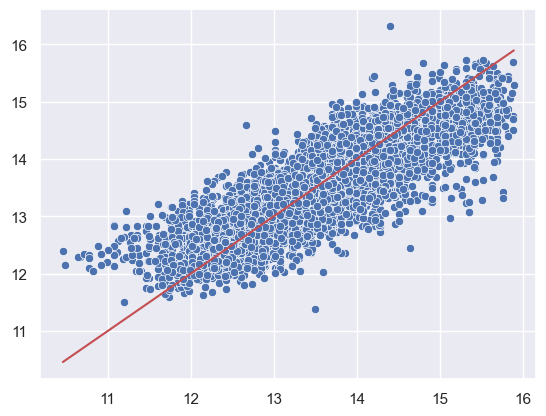

In [20]:
# linearity
sns.scatterplot(x=y_train_val, y=y_train_val_pred_lr)
sns.lineplot(x=[y_train_val.min(), y_train_val.max()], y=[y_train_val.min(), y_train_val.max()], color=sns.color_palette()[3])

<Axes: >

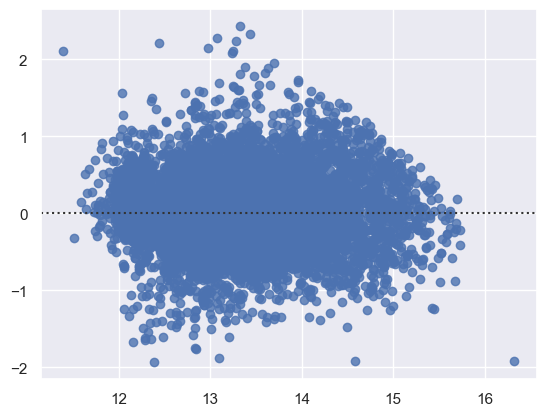

In [21]:
# homoscedasticity
sns.residplot(x=y_train_val_pred_lr, y=residuals)

<Axes: ylabel='Count'>

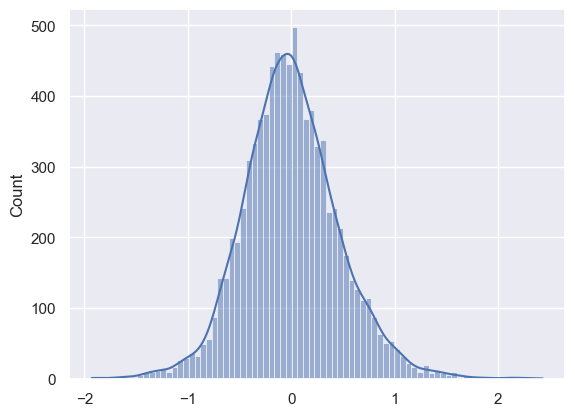

In [22]:
# normality of residuals
sns.histplot(residuals, kde=True)

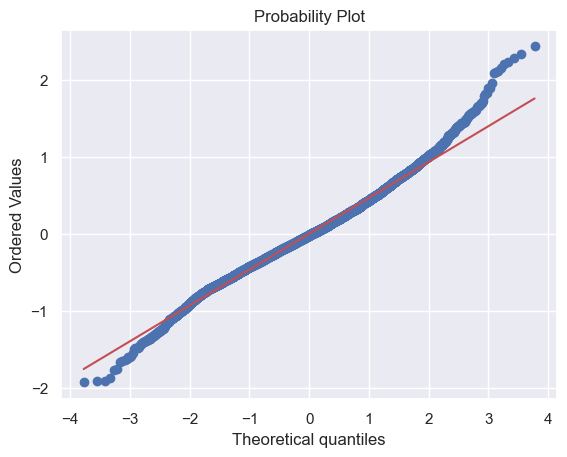

In [23]:
stats.probplot(residuals, plot=plt);

In [24]:
X_train_sm = sm.add_constant(pd.concat((df_X_train, df_X_val)))
ols_model = sm.OLS(y_train_val, X_train_sm).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1496.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:56:56   Log-Likelihood:                -5723.7
No. Observations:                8694   AIC:                         1.148e+04
Df Residuals:                    8678   BIC:                         1.159e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          10.9088      0.030    364.409      0.000      10.850      10.967
bathrooms                       2.1693      0.080     27.090      0.000       2.012       2.326
indoor_surface                  2.7543      0.070     39.166      0.000       2.616       2.892
communal_pool                   0.0241      0.019      1.304      0.192      -0.012       0.060
u/f_heating_climate_control     0.2474      0.020     12.450      0.000       0.208       0.286
gym                             0.1804      0.016     10.985      0.000       0.148       0.213
communal_garden                -0.0193      0.018     -1.101      0.271      -0.054       0.015
domotics                        0.1190      0.026      4.639      0.000       0.069       0.169
private_pool                    0.2694      0.019     14.205      0.000       0.232       0.307
private_garden                 -0.0320      0.015     -2.098      0.036      -0.062      -0.002
barbeque                       -0.0355      0.015     -2.428      0.015      -0.064      -0.007
jacuzzi                         0.0194      0.019      1.011      0.312      -0.018       0.057
luxury                          0.2765      0.013     21.050      0.000       0.251       0.302
bedrooms                       -0.8402      0.121     -6.967      0.000      -1.077      -0.604
alarm_system_security           0.0618      0.014      4.333      0.000       0.034       0.090
games_room                     -0.1474      0.025     -5.947      0.000      -0.196      -0.099
==============================================================================
Omnibus:                      317.567   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              610.205
Skew:                           0.276   Prob(JB):                    3.13e-133
Kurtosis:                       4.175   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
df_p = pd.DataFrame({
    "Coefficient": ols_model.params,
    "p-Value": ols_model.pvalues,
    f"Significant (p < {alpha})": ols_model.pvalues < alpha
})
df_p.sort_values(by="p-Value")

,Coefficient,p-Value,Significant (p < 0.05)
const,10.90880,0.00000,True
indoor_surface,2.75431,0.00000,True
bathrooms,2.16933,0.00000,True
luxury,0.27651,0.00000,True
private_pool,0.26937,0.00000,True
u/f_heating_climate_control,0.24743,0.00000,True
gym,0.18044,0.00000,True
bedrooms,-0.84021,0.00000,True
games_room,-0.14740,0.00000,True
domotics,0.11904,0.00000,True


## ElasticNet

In [26]:
en = ElasticNet(
    alpha=0.001,
    l1_ratio=0.5,
    random_state=SEED
)

In [27]:
cross_validate(en, X_train_val, y_train_val)

,r2,rmse,mae,mape
fold,,,,
1,0.71540,747324.20066,343616.67710,0.38137
2,0.71617,817882.39696,381141.21976,0.39061
3,0.72571,641768.62210,311073.49988,0.35378
4,0.72060,664581.98213,334695.90082,0.38805
5,0.72056,623475.09481,320494.46407,0.38868
6,0.71071,708775.68872,334523.42906,0.36800
7,0.74099,704917.82716,345244.61599,0.37417
8,0.70463,707715.94681,342598.11423,0.38694
9,0.73804,737571.71080,357171.28896,0.36450


## Decision Tree

In [28]:
dt = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=20, random_state=SEED)

In [29]:
cross_validate(dt, X_train_val, y_train_val_raw, is_log=False)

,r2,rmse,mae,mape
fold,,,,
1,0.67808,704909.49092,368885.22034,0.46547
2,0.70257,716486.09551,383699.09898,0.45820
3,0.67771,657746.73875,347792.95284,0.43600
4,0.68406,665905.38215,371377.98531,0.46746
5,0.66557,642679.92619,357850.08031,0.47959
6,0.68320,683570.50569,357227.62658,0.44283
7,0.70884,709329.14209,375117.25076,0.45192
8,0.66090,711777.26817,375934.96428,0.48071
9,0.71073,685650.67564,364449.03804,0.44111


In [30]:
cross_validate(dt, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.71062,715260.89380,346526.67152,0.39054
2,0.71407,746002.89563,380447.11771,0.40205
3,0.69954,652056.70339,331356.82248,0.37566
4,0.71407,663900.51496,347063.66193,0.39628
5,0.69929,652849.36509,334072.20014,0.39880
6,0.68447,716201.71371,359210.31962,0.39327
7,0.72431,743554.68947,361816.71554,0.38595
8,0.67907,731630.01339,370755.35529,0.41216
9,0.72679,726624.02604,359903.41416,0.37794


In [31]:
dt.fit(X_train_val, y_train_val_raw)

y_train_val_pred_dt = dt.predict(X_train_val)
y_test_pred_dt = dt.predict(X_test)

In [32]:
# get_errors_final(y_train_val_raw, y_train_val_pred_dt, y_test_raw, y_test_pred_dt, is_decision_tree=True)

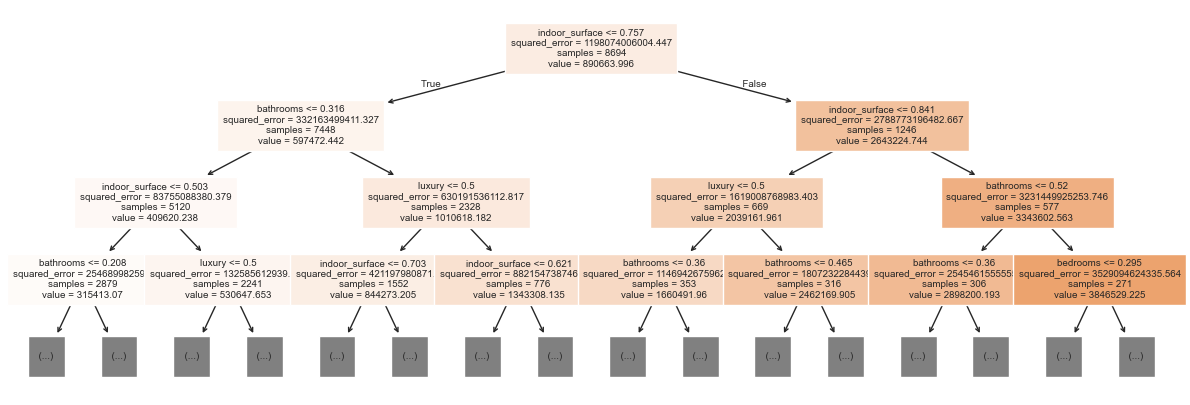

In [33]:
plt.figure(figsize=(15, 5))
plot_tree(dt, max_depth=3, fontsize=7, feature_names=df_train.columns, filled=True);

## Random Forest

In [34]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=20, min_samples_leaf=20, random_state=SEED)

In [35]:
cross_validate(rf, X_train_val, y_train_val_raw, is_log=False)

,r2,rmse,mae,mape
fold,,,,
1,0.70156,691396.67224,355010.24791,0.44925
2,0.72446,687620.54236,365675.04147,0.44338
3,0.70692,611074.65015,326302.95843,0.42609
4,0.70696,638378.32883,350205.09593,0.44997
5,0.68593,610716.57896,341981.22979,0.46847
6,0.70444,657760.56805,344958.94807,0.43228
7,0.72651,684482.23528,355109.58439,0.43857
8,0.68212,690972.64149,368774.95977,0.46648
9,0.73246,662753.57588,347557.59114,0.42204


In [36]:
cross_validate(rf, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.72608,716113.32841,340850.10067,0.37512
2,0.73258,728768.99264,361987.46693,0.38300
3,0.72496,632438.09493,313822.57611,0.35600
4,0.73301,651849.35762,335256.87096,0.37875
5,0.72262,613439.75236,318991.30971,0.38416
6,0.71016,681892.54038,337204.14542,0.37382
7,0.74586,713692.30810,340993.60357,0.36948
8,0.70028,701763.32142,351262.97800,0.39373
9,0.74163,693224.43299,344943.54643,0.36461


In [37]:
rf.fit(X_train_val, y_train_val_raw)
y_train_val_pred_rf = rf.predict(X_train_val)
y_test_pred_rf = rf.predict(X_test)

In [38]:
# get_errors_final(y_train_val_raw, y_train_val_pred_rf, y_test_raw, y_test_pred_rf, is_decision_tree=True)

## Gradient Boosting

In [39]:
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=SEED
)

In [40]:
cross_validate(gb, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.73972,693306.20852,326952.41559,0.36282
2,0.74275,709915.57887,357128.67090,0.37476
3,0.73580,629557.37215,306642.39590,0.34587
4,0.74140,628436.26649,326763.05557,0.37077
5,0.72614,601735.53994,317273.70743,0.38388
6,0.71855,687170.37479,334392.61020,0.36255
7,0.75306,695474.64838,335750.91661,0.36014
8,0.71396,697718.92090,344254.10998,0.38019
9,0.75193,677219.55856,337760.33000,0.35237


## XGBoost

In [41]:
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    n_jobs=-1,
    max_depth=5,
    random_state=SEED
)

In [42]:
cross_validate(xgb, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.73830,692874.47589,328648.85632,0.36630
2,0.74257,724001.87112,362071.07430,0.37667
3,0.73896,630596.33183,305167.12845,0.34291
4,0.74411,624413.73251,322333.90018,0.36824
5,0.73158,597727.17813,311473.52501,0.37646
6,0.71694,693632.33692,337834.61989,0.36669
7,0.75336,695390.90801,335788.66652,0.35913
8,0.71771,694355.49895,343862.06982,0.37892
9,0.75149,680823.73457,338688.97866,0.35354


## KNN

In [43]:
np.sqrt(0.9 * y_train_val.shape[0])

np.float64(88.45676910220043)

In [44]:
k = 89
knn = KNeighborsRegressor(n_neighbors=k)

In [45]:
cross_validate(knn, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.66847,861977.84034,380125.39229,0.38871
2,0.66153,892325.09942,416741.96231,0.39919
3,0.68320,706199.57461,333849.38662,0.36418
4,0.67558,759587.90239,367711.02759,0.39133
5,0.68055,679661.88780,335008.04805,0.39230
6,0.66418,760892.10063,348935.58923,0.37161
7,0.68162,835204.36945,391499.74243,0.40009
8,0.67718,769906.17805,365876.96731,0.38779
9,0.69293,819454.17424,384521.77932,0.36815


In [46]:
knn.fit(X_train_val, y_train_val_raw)
y_train_val_pred_knn = knn.predict(X_train_val)
y_test_pred_knn = knn.predict(X_test)

In [47]:
# get_errors_final(y_train_val_raw, np.expm1(y_train_val_pred_knn), y_test_raw, np.expm1(y_test_pred_knn), is_decision_tree=True)

## SVR

In [48]:
svr = SVR(kernel="rbf", C=1, epsilon=0.1)

In [49]:
cross_validate(svr, X_train_val, y_train_val, is_log=True)

,r2,rmse,mae,mape
fold,,,,
1,0.72328,748998.73646,340770.99219,0.36449
2,0.72012,791450.40970,383721.31254,0.38411
3,0.72987,650389.02320,310757.21067,0.33935
4,0.72618,672708.18574,334716.50262,0.37376
5,0.72474,613015.21190,312240.66316,0.37261
6,0.71234,710587.87505,339667.05101,0.36172
7,0.74733,712573.30094,342179.68850,0.35830
8,0.71495,690281.81932,339355.98808,0.37186
9,0.74462,715237.22580,344787.17699,0.34455


In [50]:
svr.fit(X_train_val, y_train_val_raw)
y_train_val_pred_svr = svr.predict(X_train_val)
y_test_pred_svr = svr.predict(X_test)

In [51]:
# get_errors_final(y_train_val_raw, np.expm1(y_train_val_pred_svr), y_test_raw, np.expm1(y_test_pred_svr), is_decision_tree=True)

## MLP

In [52]:
nn = MLPRegressor(
    hidden_layer_sizes=[100, 100],
    random_state=SEED,
    batch_size=64,
    activation="tanh",
    alpha=0.001,
    learning_rate_init=0.001,
    solver="adam",
    max_iter=500)

In [53]:
nn.fit(X_train, y_train);

<Axes: >

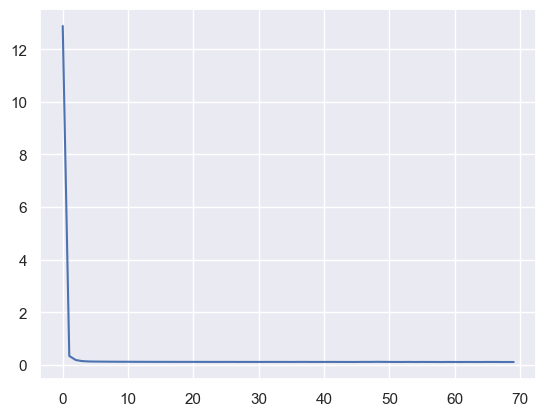

In [54]:
sns.lineplot(nn.loss_curve_)

In [55]:
y_train_pred_nn = np.expm1(nn.predict(X_train))
y_val_pred_nn = np.expm1(nn.predict(X_val))

In [56]:
get_errors(y_train_raw, y_train_pred_nn)

r2          0.70909
rmse   736667.23950
mae    345227.26143
mape        0.34360
dtype: float64

In [57]:
get_errors(y_val_raw, y_val_pred_nn)

r2          0.70754
rmse   729851.39990
mae    344782.38024
mape        0.33757
dtype: float64

In [58]:
nn.fit(X_train_val, y_train_val)

y_train_val_pred_nn = nn.predict(X_train_val)
y_test_pred_nn = nn.predict(X_test)

In [59]:
# get_errors_final(y_train_val_raw, np.expm1(y_train_val_pred_nn), y_test_raw, np.expm1(y_test_pred_nn))